<a href="https://colab.research.google.com/github/NainaMKumar/Arrythmia_detection/blob/main/Arrythmia_Detection_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install wfdb

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy
import wfdb
import os
from pathlib import Path
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras import regularizers
from keras.optimizers import Adam
from keras.metrics import Precision
from keras.metrics import Recall
from keras.metrics import AUC

In [8]:
dataset_directory = Path('/content/mit-bih-arrhythmia-database-1.0.0.zip')

In [9]:
from zipfile import ZipFile

with ZipFile(dataset_directory, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [10]:
dataset_directory = Path('/content/mit-bih-arrhythmia-database-1.0.0')

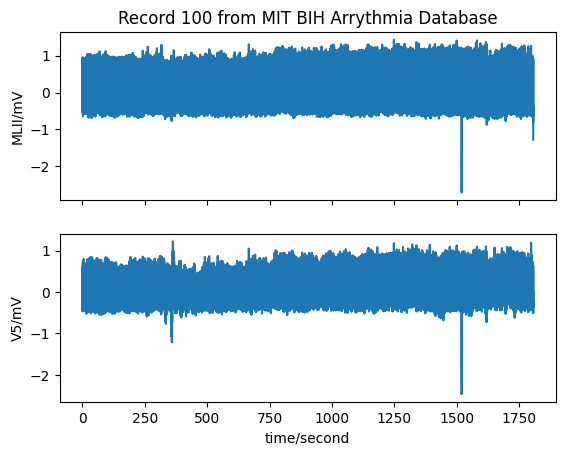

{'record_name': '100',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'sig_name': ['MLII', 'V5'],
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [995, 1011],
 'checksum': [-22131, 20052],
 'block_size': [0, 0]}

In [11]:
# Demo 1 - Read a WFDB record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
record = wfdb.rdrecord(dataset_directory / '100')
wfdb.plot_wfdb(record=record, title='Record 100 from MIT BIH Arrythmia Database')
display(record.__dict__)

In [12]:
# Demo 2 - Read certain channels and sections of the WFDB record using the simplified 'rdsamp' function
# which returns a numpy array and a dictionary. Show the data.
signals, fields = wfdb.rdsamp(dataset_directory / '100', channels=[0, 1], sampfrom=100, sampto=15000)
display(signals)
display(fields)

array([[-0.33 , -0.195],
       [-0.335, -0.185],
       [-0.33 , -0.185],
       ...,
       [-0.52 , -0.275],
       [-0.54 , -0.315],
       [-0.545, -0.31 ]])

{'fs': 360,
 'sig_len': 14900,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}

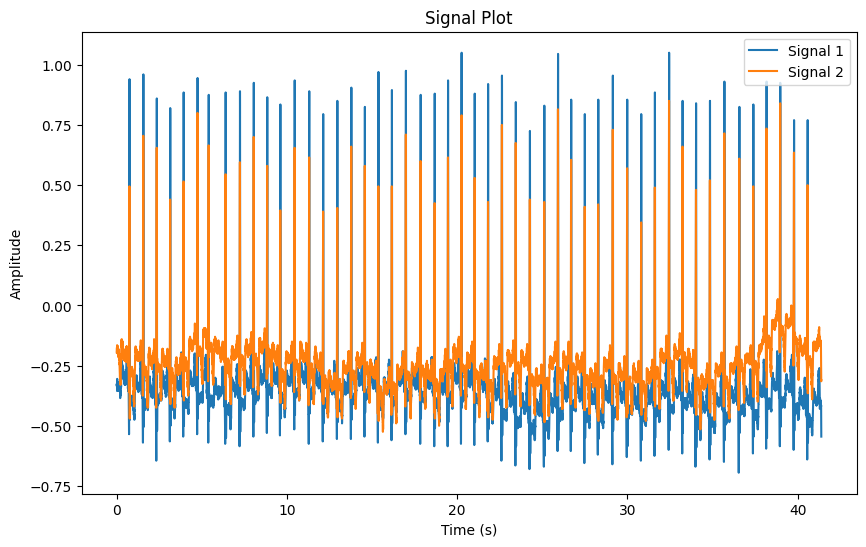

In [13]:
# Extract signal data
signal_1 = signals[:, 0]
signal_2 = signals[:, 1]

# Extract sampling frequency and number of samples
fs = fields['fs']
n_samples = fields['sig_len']

# Calculate time array
time = np.arange(n_samples) / fs

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(time, signal_1, label='Signal 1')
plt.plot(time, signal_2, label='Signal 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal Plot')
plt.legend()
plt.show()

In [14]:
ecg_signals = []

for file in dataset_directory.glob('*.dat'):
    print(file.stem)
    signals, fields = wfdb.rdsamp(dataset_directory / file.stem, channels=[1], sampfrom=100, sampto=15000)
    ecg_signals.append(signals)

ecg_signals = np.array(ecg_signals)
print(ecg_signals.shape)

100
103
200
234
233
201
214
119
122
220
114
207
112
124
202
121
217
209
102
205
212
213
107
215
219
116
223
117
104
106
210
118
105
232
115
221
203
208
113
101
222
230
108
228
231
111
109
123
(48, 14900, 1)


In [15]:
def plot_signal(signal):

    # Extract sampling frequency and number of samples
    fs = fields['fs']
    signal_length = len(signal)

    # Calculate time array
    time = np.arange(signal_length) / fs

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(time, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.title('Signal Plot')
    plt.show()

In [16]:
def scale_signal(ecg_signal):
    # Find the minimum value in the signal
    min_val = np.min(ecg_signal)

    # Calculate the scaling factor to shift the signal above 0
    scaling_factor = abs(min_val) + 1  # Add 1 for a small margin

    # Scale the signal by adding the scaling factor
    scaled_signal = ecg_signal + scaling_factor

    return scaled_signal

In [17]:
ecg_signal = ecg_signals[0]
ecg_signal = np.array(ecg_signal)

scaled_ecg_signal = scale_signal(ecg_signal)
scaled_ecg_signal = np.array(scaled_ecg_signal)

In [18]:
def signal_filter_powerline(signal, sampling_rate, powerline=50):
    """Filter out 50 Hz powerline noise by smoothing the signal with a moving average kernel with the width of one
    period of 50Hz."""

    if sampling_rate >= 100:
        b = np.ones(int(sampling_rate / powerline))
    else:
        b = np.ones(2)
    a = [len(b)]
    y = scipy.signal.filtfilt(b, a, signal, axis = 0)
    return y

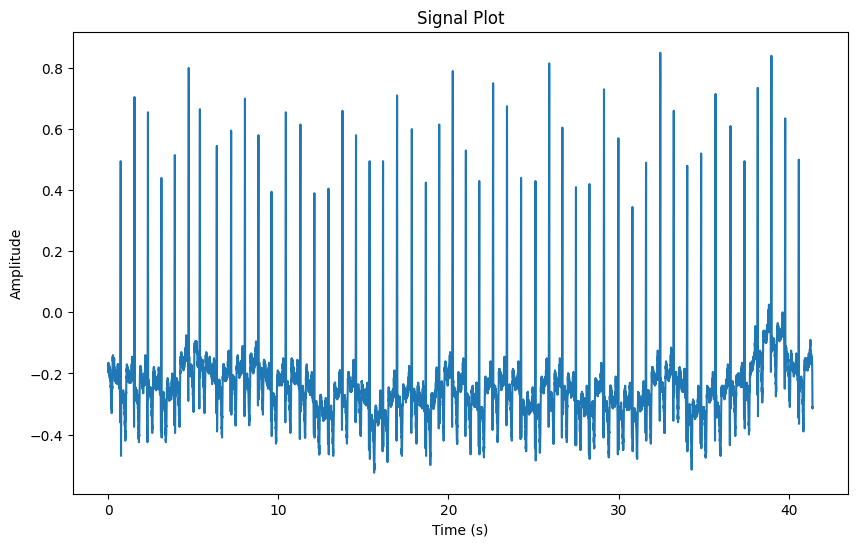

In [19]:
plot_signal(ecg_signal)

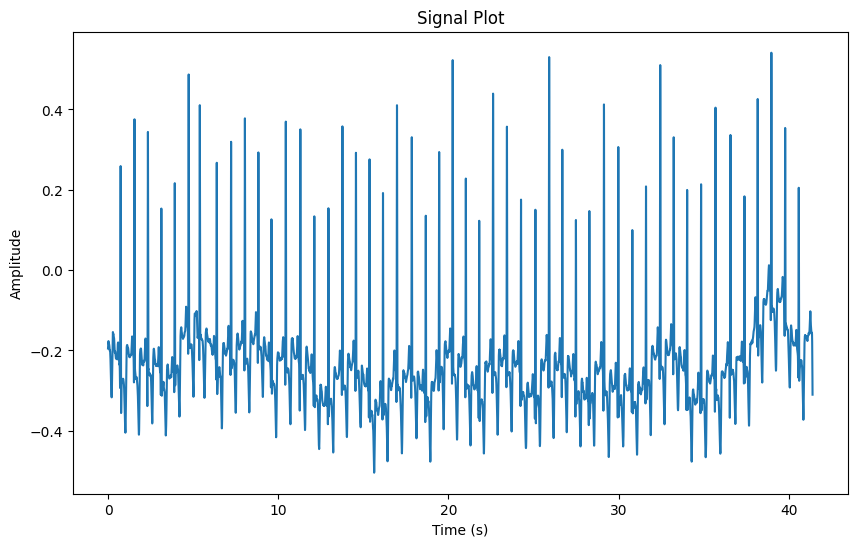

In [20]:
denoised_signal = signal_filter_powerline(ecg_signal, fields['fs'])
plot_signal(denoised_signal)

In [21]:
def remove_baseline_wander(ecg_signal, sampling_frequency, cutoff_frequency = 1.2, filter_order=3):
    nyquist_frequency = 0.5 * sampling_frequency
    normalized_cutoff = cutoff_frequency / nyquist_frequency

    # Design a high-pass Butterworth filter
    b, a = signal.butter(filter_order, normalized_cutoff, btype='high', analog=False)

    # Apply the high-pass filter to remove baseline wander
    baseline_removed_signal = signal.filtfilt(b, a, ecg_signal, axis = 0)

    return baseline_removed_signal

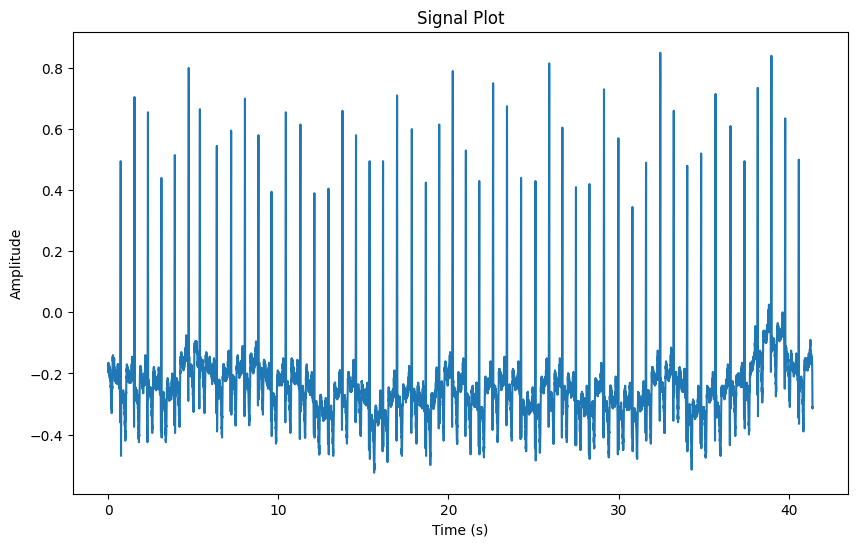

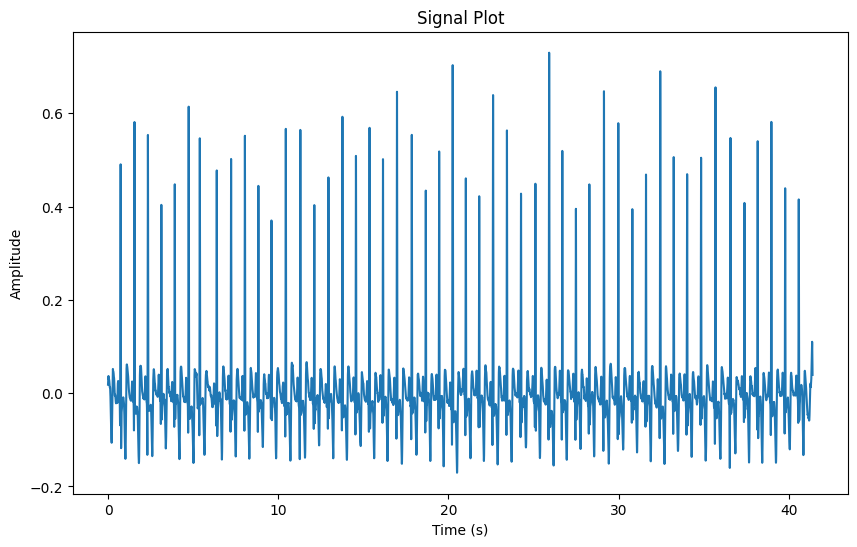

In [22]:
baseline_removed_signal = remove_baseline_wander(denoised_signal, fields['fs'])

plot_signal(ecg_signal)
plot_signal(baseline_removed_signal)

In [23]:
def normalize_signal(signal):
    norm_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    return norm_signal
    # scaler = MinMaxScaler()
    # signal = signal.reshape(-1, 1)
    # scaled_signal = scaler.fit_transform(signal)
    # return scaled_signal

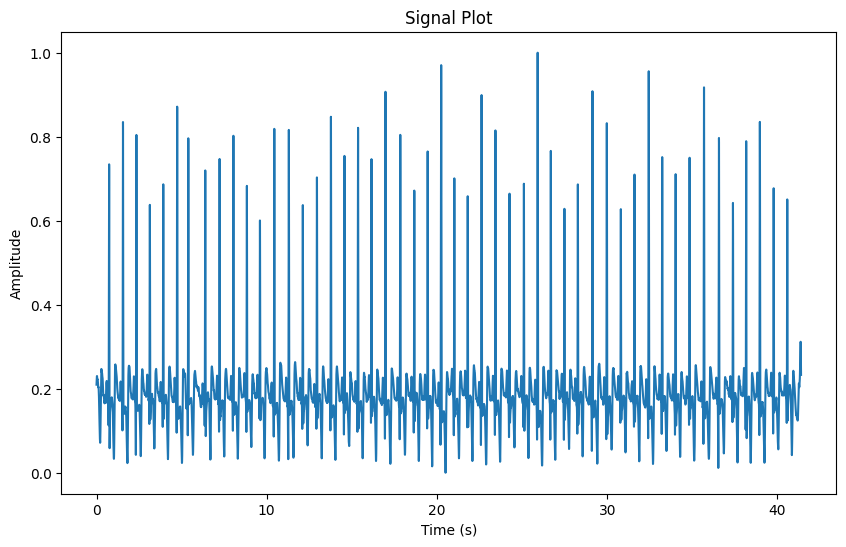

-0.17069545980278017
0.7298305409166082
0.0
1.0


In [24]:
normalized_signal = normalize_signal(baseline_removed_signal)
plot_signal(normalized_signal)

print(np.min(baseline_removed_signal))
print(np.max(baseline_removed_signal))
print(np.min(normalized_signal))
print(np.max(normalized_signal))


In [77]:
X = []

for ecg_signal in ecg_signals:
    denoised_signal = signal_filter_powerline(ecg_signal, fields['fs'])
    filtered_signal = remove_baseline_wander(denoised_signal, fields['fs'])
    normalized_signal = tf.keras.utils.normalize(np.array(filtered_signal))
    X.append(normalized_signal)

X = np.array(X)
# print(X)

In [111]:
y = []

for file in dataset_directory.glob('*.atr'):
    print(file.stem)
    annotations = wfdb.rdann(str(dataset_directory / file.stem), 'atr', sampto=15000)
    diagnosis = annotations.aux_note
    y.append(diagnosis)

print(y)
print(len(y))

107
124
232
205
109
220
233
234
119
215
207
208
219
202
123
200
213
108
212
214
111
217
115
100
103
117
118
209
104
105
102
228
222
203
122
114
231
121
223
106
201
101
113
230
221
116
210
112
[['(P\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['(N\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['(SBR\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['(N\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['(N\

In [112]:
y = [[item.strip().replace('\x00', '') for item in inner_list if item.strip()] for inner_list in y]

y = [[item.replace('(', '') for item in inner_list] for inner_list in y]
print(y)
print(len(y))

[['P'], ['N'], ['SBR'], ['N'], ['N'], ['N'], ['N', 'VT', 'N'], ['N'], ['N', 'B', 'N', 'B'], ['N'], ['B', 'VT', 'N', 'VFL'], ['N'], ['AFIB'], ['N'], ['N'], ['B', 'N', 'B'], ['N'], ['N'], ['N'], ['N'], ['N'], ['P'], ['N'], ['N'], ['N'], ['N'], ['N'], ['N'], ['P'], ['N'], ['P'], ['N', 'B', 'N'], ['N'], ['AFIB'], ['N'], ['N'], ['N', 'MISSB'], ['N'], ['N'], ['N'], ['AFIB'], ['N'], ['N'], ['N', 'PREX', 'N', 'PREX', 'N', 'PREX'], ['AFIB'], ['N'], ['AFIB'], ['N']]
48


In [113]:
y_dict = {'N': 0, 'P': 1, 'B': 2, 'AFIB': 3, 'MISSB': 4, 'PREX': 5, 'VT': 6, 'VFL': 7, 'SBR': 8}
y = [[y_dict.get(k) for k in lst] for lst in y]
print(y)

[[1], [0], [8], [0], [0], [0], [0, 6, 0], [0], [0, 2, 0, 2], [0], [2, 6, 0, 7], [0], [3], [0], [0], [2, 0, 2], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0, 2, 0], [0], [3], [0], [0], [0, 4], [0], [0], [0], [3], [0], [0], [0, 5, 0, 5, 0, 5], [3], [0], [3], [0]]


In [114]:
mlb = MultiLabelBinarizer()
y_transformed = mlb.fit_transform(y)
print(y_transformed)
y_transformed= np.array(y_transformed)

num_classes = mlb.classes_

[[0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 1 1 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0

In [115]:
print(y_transformed.shape)

(48, 9)


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size = 0.3, random_state = 42)

In [117]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33, 14900, 1)
(15, 14900, 1)
(33, 9)
(15, 9)


In [118]:
#compute class weights

reverse_dict = {v: k for k, v in y_dict.items()}
class_frequencies = np.sum(y_transformed, axis=0)
print(class_frequencies)
num_classes = len(y_dict)

class_weights = {reverse_dict[i]: len(y_transformed) / (num_classes * class_frequencies[i]) for i in range(num_classes)}
class_weights = {y_dict[label]: class_weights[label] for label in class_weights}
print(class_weights)

[38  4  4  5  1  1  2  1  1]
{0: 0.14035087719298245, 1: 1.3333333333333333, 2: 1.3333333333333333, 3: 1.0666666666666667, 4: 5.333333333333333, 5: 5.333333333333333, 6: 2.6666666666666665, 7: 5.333333333333333, 8: 5.333333333333333}


In [119]:
# model = keras.Sequential()
# model.add(layers.Conv1D(filters = 64, kernel_size=3, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv1D(filters= 128, kernel_size=3, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv1D(filters = 256, kernel_size = 3, activation = 'relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling1D(pool_size=2, strides = 2))
# model.add(layers.Flatten())
# model.add(layers.Dense(100, activation='relu', kernel_regularizer = regularizers.l2(0.01)))
# model.add(layers.Dense(num_classes, activation='softmax'))

In [120]:
model = keras.Sequential()
model.add(layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu'))
model.add(layers.MaxPooling1D(pool_size = 2))
model.add(layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu'))
model.add(layers.MaxPooling1D(pool_size = 2))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(100, activation = 'relu', kernel_regularizer = regularizers.l2(0.0003)))
model.add(layers.Dense(num_classes, activation = 'softmax', kernel_regularizer = regularizers.l2(0.0003)))


In [121]:
# model = keras.Sequential()
# model.add(layers.LSTM(64))
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(100, activation = 'relu'))
# model.add(layers.Dense(50, activation = 'relu'))
# model.add(layers.Dense(num_classes, activation = 'softmax'))

In [122]:
# # define model
# model = keras.Sequential()
# model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.MaxPooling1D(pool_size=2))
# # model.add(layers.Flatten())
# model.add(layers.LSTM(100))
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(100, activation='relu'))
# model.add(layers.Dense(num_classes, activation='softmax'))

In [123]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [124]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose = 1)

In [125]:
batch_size = 32

model.compile(
    loss= 'categorical_crossentropy',
    optimizer=optimizer,
    metrics = ['accuracy', Precision(), Recall(), AUC(curve = 'ROC')]
)

history = model.fit(
    X_train,
    y_train,
    epochs= 16,
    batch_size=batch_size,
    shuffle=False,
    validation_data = (X_test, y_test),
    class_weight = class_weights,
    # callbacks = [callback]
)

Epoch 1/16
2/2 [==============================] - 21s 7s/step - loss: 1.1881 - accuracy: 0.0303 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.3898 - val_loss: 2.6620 - val_accuracy: 0.2000 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.4953
Epoch 2/16
2/2 [==============================] - 12s 5s/step - loss: 1.1846 - accuracy: 0.0303 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.4317 - val_loss: 2.6553 - val_accuracy: 0.1333 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.5233
Epoch 3/16
2/2 [==============================] - 12s 5s/step - loss: 1.1819 - accuracy: 0.0303 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.4837 - val_loss: 2.6485 - val_accuracy: 0.1333 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.5532
Epoch 4/16
2/2 [==============================] - 13s 5s/step - loss: 1.1793 - accuracy: 0.0606 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.5156

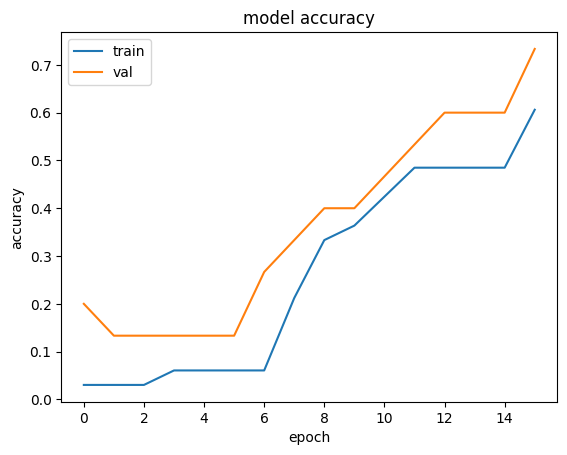

In [126]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

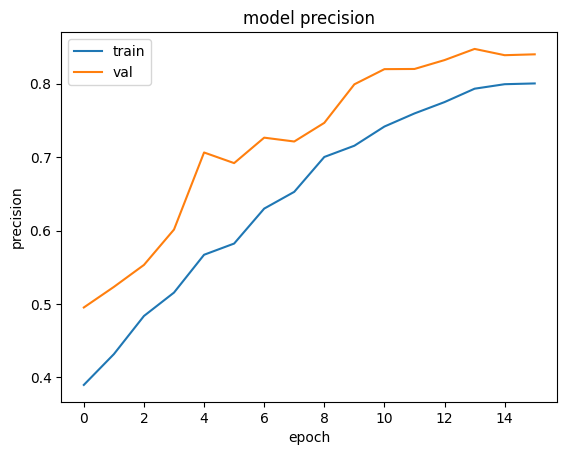

In [131]:
plt.plot(history.history['auc_4'])
plt.plot(history.history['val_auc_4'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [128]:
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test, batch_size = 64)

1/1 [==============================] - 1s 669ms/step - loss: 2.5593 - accuracy: 0.7333 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.8400
